<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/predict_plane_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# predict plane state

Uses actions and a input state to predict the outputstate.

## imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

Using TensorFlow backend.


2.0.0-rc2


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6506714422744143479
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9445666636864103508
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5362004702129574304
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 709947053083502333
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## load files

In [0]:
file = 'dataset_all.csv'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
working dir: /content/drive/My Drive/xplane_data


## actions & states
actions and states at time t are the input for the network.

the states at time t + 1 are the desired output of the network.


In [6]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '
col_heading_mag = '   hding,__mag '
col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,
    col_rpm_prop,
    col_throttle,
]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'


label_prefix = 't+1_'
cols_label = [label_prefix + col_state for col_state in cols_state]
print(cols_label)


['t+1_   ____Q,rad/s ', 't+1_   _beta,__deg ', 't+1_   _roll,__deg ', 't+1_   ____R,rad/s ', 't+1_   pitch,__deg ', 't+1_   ____P,rad/s ', 't+1_   __VVI,__fpm ', 't+1_   __alt,ftmsl ', 't+1_   Vtrue,_ktas ', 't+1_   rpm_1,_prop ', 't+1_   thro1,_part ']


In [12]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_features = load_xplane_csv(file, cols_features)

df_labels = load_xplane_csv(file, cols_label)

print(len(df_features))
print(len(df_labels))
assert(len(df_features) == len(df_labels))


380538
380538


In [0]:
def split_train_test(dataset):
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test


In [0]:
features = df_features.values
labels = df_labels.values

train_X, test_X = split_train_test(features)
train_Y, test_Y = split_train_test(labels)

In [15]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(254960, 14)
(254960, 11)
(125578, 14)
(125578, 11)


In [17]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]


baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(features_nr, activation='relu', 
                       input_shape=(features_nr,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(target_nr)
])

baseline_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['accuracy', 'binary_crossentropy', 'mean_squared_error'])

baseline_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 14)                210       
_________________________________________________________________
batch_normalization_2 (Batch (None, 14)                56        
_________________________________________________________________
dense_5 (Dense)              (None, 400)               6000      
_________________________________________________________________
batch_normalization_3 (Batch (None, 400)               1600      
_________________________________________________________________
dense_6 (Dense)              (None, 400)               160400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 400)               1600      
_________________________________________________________________
dense_7 (Dense)              (None, 11)               

In [18]:
baseline_history = baseline_model.fit(train_X,
                                      train_Y,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_X, test_Y),
                                      verbose=2)


Train on 254960 samples, validate on 125578 samples
Epoch 1/20
254960/254960 - 8s - loss: nan - accuracy: 0.0015 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 2/20
254960/254960 - 6s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 3/20
254960/254960 - 5s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 4/20
254960/254960 - 6s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 5/20
254960/254960 - 6s - loss: nan - accuracy: 0.0014 - binary_crosse

In [0]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]


bigger_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(features_nr, activation='relu', 
                       input_shape=(features_nr,)),
    keras.layers.Dense(1200, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(target_nr)
])

bigger_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['accuracy', 'binary_crossentropy', 'mean_squared_error'])

bigger_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1200)              18000     
_________________________________________________________________
dense_6 (Dense)              (None, 600)               720600    
_________________________________________________________________
dense_7 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_8 (Dense)              (None, 11)                6611      
Total params: 1,106,021
Trainable params: 1,106,021
Non-trainable params: 0
_________________________________________________________________


In [0]:
bigger_history = bigger_model.fit(train_X,
                                      train_Y,
                                      epochs=20,
                                      validation_data=(test_X, test_Y),
                                      verbose=2)


Train on 254960 samples, validate on 125578 samples
Epoch 1/20
254960/254960 - 56s - loss: nan - accuracy: 0.0021 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 2/20
254960/254960 - 56s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 3/20
254960/254960 - 55s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 4/20
254960/254960 - 56s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 5/20
254960/254960 - 56s - loss: nan - accuracy: 0.0014 - binary_c

In [0]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]


smaller_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(features_nr, activation='relu', 
                       input_shape=(features_nr,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(target_nr)
])

smaller_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['accuracy', 'binary_crossentropy', 'mean_squared_error'])

smaller_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 11)                1111      
Total params: 12,921
Trainable params: 12,921
Non-trainable params: 0
_________________________________________________________________


In [0]:
smaller_history = smaller_model.fit(train_X,
                                      train_Y,
                                      epochs=20,
                                      validation_data=(test_X, test_Y),
                                      verbose=2)


Train on 254960 samples, validate on 125578 samples
Epoch 1/20
254960/254960 - 47s - loss: nan - accuracy: 0.0022 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 2/20
254960/254960 - 46s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 3/20
254960/254960 - 46s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 4/20
254960/254960 - 46s - loss: nan - accuracy: 0.0014 - binary_crossentropy: nan - mean_squared_error: nan - val_loss: nan - val_accuracy: 7.6447e-04 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 5/20
254960/254960 - 46s - loss: nan - accuracy: 0.0014 - binary_c

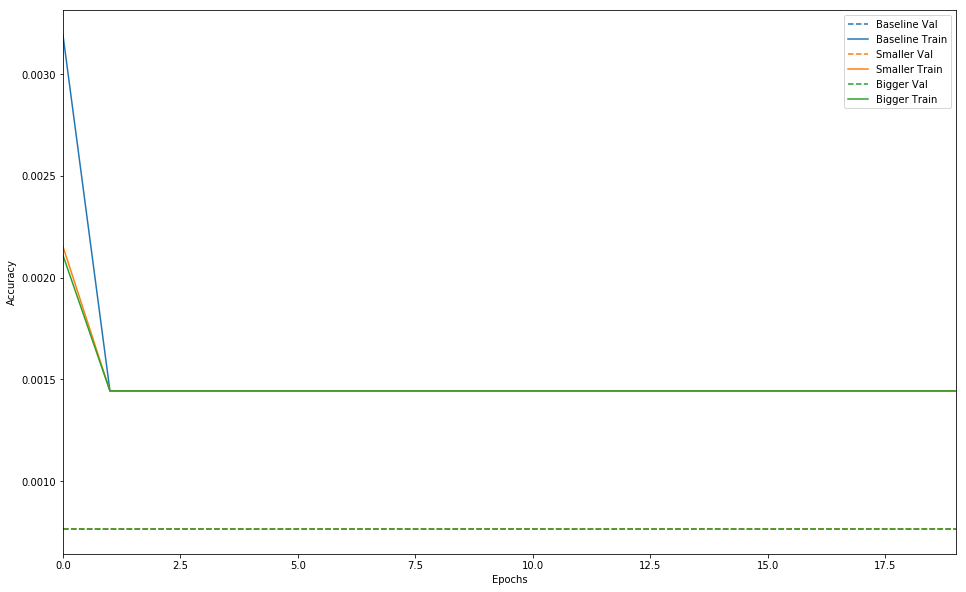

In [0]:
def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])
